In [1]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np
%matplotlib inline 

In [2]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    #get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    #initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
               
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(len(cat_locs)):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(len(dog_locs)):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y 

In [3]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

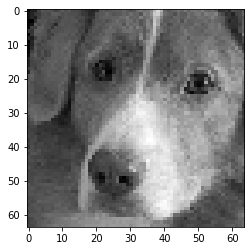

In [4]:
#Test to see if read_data and show_image working
X,y = read_data()
show_image(X,1505)

In [5]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the accuracy of the guesses out of 100%.

def calculate_accuracy(ytrue, yguess):
    
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    correct = sum((ytrue == yguess))
    total = len(ytrue)
    accuracy = 100*float(correct)/float(total)
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return accuracy

In [6]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

In [7]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real
    return pcaX

In [120]:
#This function takes in a data matrix X and a label
#vector y and outputs the average cat image and average dog image.

def average_pet(X,y):
    
    avgcat = np.zeros((1,4096)) #initialize avgcat 
    avgdog = np.zeros((1,4096)) #initialize avgdog
    for i in range(len(y)): #for loop of length equal to number of rows in y
        if y[i] == -1: #if y = -1 add x row to avgcat
            temp = X[i,:]
            avgcat = np.vstack([avgcat, temp])
        else: #if y = 1 add x row to avgdog
            temp = X[i,:]
            avgdog = np.vstack([avgdog, temp])
    avgcat = avgcat.mean(axis=0) #find cat avg
    avgdog = avgdog.mean(axis=0) #find dog avg
    avgcat = avgcat.reshape(1,4096) #reshape to useable format
    avgdog = avgdog.reshape(1,4096) #reshape to useable format
    
    return avgcat, avgdog

In [9]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to whether
#each row of Xtest is closer to the average cat or average dog.

def closest_average(Xtrain,ytrain,Xrun):
    
    yguess = np.zeros((1,1)) #initialize yguess
    avgcat, avgdog = average_pet(Xtrain,ytrain) #find avg of training data
    col = len(Xrun) #find number of rows in Xrun
    for i in range(col): 
        temp = Xrun[i,:] #find image data in Xrun row i
        temp = temp.reshape(1,4096) #reshape
        discat = np.linalg.norm(avgcat-temp) #test distance from avgcat
        disdog = np.linalg.norm(avgdog-temp) #test distance from avgdog
        if i == 0: #if first image begin yguess array
            if discat < disdog: #if closer to cat add -1 to yguess
                yguess = [-1.]
            else: #if closer to dog add 1 to yguess
                yguess = [1.]
        else:
            if discat < disdog: #if closer to cat add -1 to yguess
                temp = [-1.]
                yguess = np.vstack([yguess, temp])
            else: #if closer to dog add 1 to yguess
                temp = [1.]
                yguess = np.vstack([yguess, temp])
    
    return yguess

In [77]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess. Each guess is found
#by searching through Xtrain to find the closest row, and then 
#outputting its label.

def nearest_neighbor(Xtrain,ytrain,Xrun):
    
    col = len(Xrun) #find number of rows in Xrun
    col2 = len(Xtrain) #find number of rows in Xtrain
    for i in range(col):
        mindis = 10000000000000000 #reset mindis to a large number
        min_i = 10000000000000000 #reset min_i to a large number
        temp = Xrun[i,:] #find image data of row i to test aganist all training data
        for j in range(col2):
            temp2 = Xtrain[j,:] #find image data of Xtrain in row j
            dis = np.linalg.norm(temp-temp2) #find dis
            if dis <= mindis: #if it finds a smaller dis make it new mindis
                mindis = dis
                min_i = j #remember position mindis is at
        if i == 0: #start yguess
            yguess = ytrain[min_i,:] #put the guess of min dis in the yguess array
        else:
            temp3 = ytrain[min_i,:]
            yguess = np.vstack([yguess, temp3]) #put the guess of min dis in the yguess array
            
    return yguess

In [68]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute ordinary-least-squares
#vector b. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to the sign
#of the linear prediction.

def linear_regression(Xtrain,ytrain,Xrun):
    
    Xt = Xtrain.transpose() #find transpose of Xtrain
    Xt2 = np.linalg.pinv(np.dot(Xt,Xtrain)) #find inverse of (Xtrain*Xtrain_transpose)
    Xt3 = np.dot(Xt,ytrain) #Xtrian_transpose*ytrian
    bsol = np.dot(Xt2,Xt3) #find bsol
    
    yguess = np.sign(np.dot(Xrun,bsol)) #Xrun*bsol is run through the signed function and put into yguess
    
    return yguess

In [121]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the PCA basis. 
#It also takes in a data matrix Xrun and a dimension k
#and uses the top-k vectors in the PCA basis to reduce the 
#dimension of Xtrain and Xrun. Finally, it uses the reduced data
#as inputs to the linear_regression function to produce 
#a vector of label guesses yguess.

def pca_regression(Xtrain,ytrain,Xrun, k):
    
    V = pca(Xtrain) #get v form pca function
    Vk = V[:,:k] #get the first k columns
    
    Xlen_train = len(Xtrain) #find length of Xtrain
    Xlen_test = len(Xrun) #find length of Xrun
    
    E_train = np.ones((Xlen_train, 1)) #use length of Xtrain to set up ones
    E_test = np.ones((Xlen_test, 1)) #use length of Xrun to set up ones
    
    Xtrans_train = Xtrain.transpose() #find transpose of Xtrain
    Xtrans_test = Xrun.transpose() #find transpose of Xrun
    
    av_trian = (1/Xlen_train)* np.dot(Xtrans_train, E_train) #find average of training data
    av_test = (1/Xlen_test)* np.dot(Xtrans_test, E_test) #find average of test data
    
    av_trans_train = av_trian.transpose() #transpose average of train
    av_trans_test = av_test.transpose() #transpose average of test
    
    XC_train = np.subtract(Xtrain,np.dot(E_train,av_trans_train)) #find centered training data
    XC_test = np.subtract(Xrun,np.dot(E_test,av_trans_test)) #find centered test data
    
    Xtrain_reduced = np.dot(XC_train,Vk) #find reduced training data
    Xtest_reduced = np.dot(XC_test,Vk) #find reduced test data
    
    yguess = linear_regression(Xtrain_reduced,ytrain,Xtest_reduced) #find yguess by passing reduced data into linear regression function
    
    return yguess

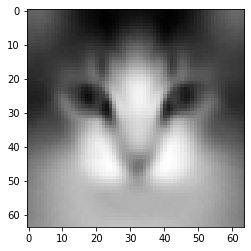

In [126]:
avgcat, avgdog = average_pet(X,y)
show_image(avgcat,0)

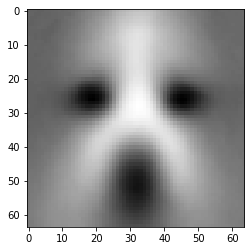

In [127]:
show_image(avgdog,0)

In [128]:
Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)
yguess_test = closest_average(Xtrain,ytrain,Xtest)
yguess_train = closest_average(Xtrain,ytrain,Xtrain)
per_test = calculate_accuracy(ytest, yguess_test)
per_train = calculate_accuracy(ytrain, yguess_train)
print(per_test)
print(per_train)

78.25
81.0625


In [129]:
yguess_test2 = nearest_neighbor(Xtrain,ytrain,Xtest)
yguess_train2 = nearest_neighbor(Xtrain,ytrain,Xtrain)
per_test2 = calculate_accuracy(ytest, yguess_test2)
per_train2 = calculate_accuracy(ytrain, yguess_train2)
print(per_test2)
print(per_train2)

82.0
100.0


In [130]:
yguess_test3 = linear_regression(Xtrain,ytrain,Xtest)
yguess_train3 = linear_regression(Xtrain,ytrain,Xtrain)
per_test3 = calculate_accuracy(ytest, yguess_test3)
per_train3 = calculate_accuracy(ytrain, yguess_train3)
print(per_test3)
print(per_train3)

77.5
100.0


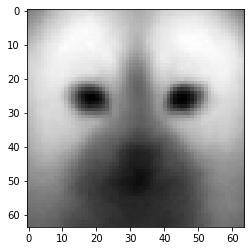

In [88]:
out = pca(Xtrain)
out = out.transpose()
show_image(out,0)

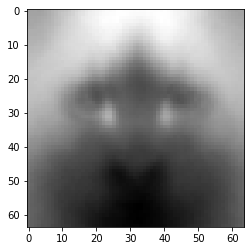

In [89]:
show_image(out,1)

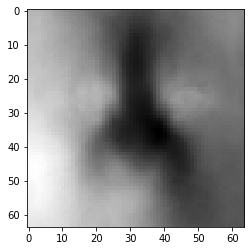

In [90]:
show_image(out,2)

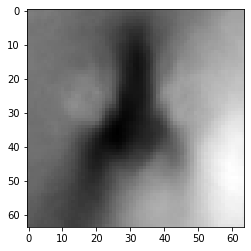

In [91]:
show_image(out,3)

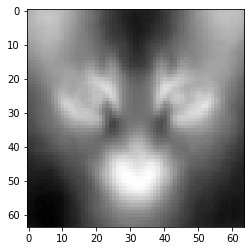

In [92]:
show_image(out,4)

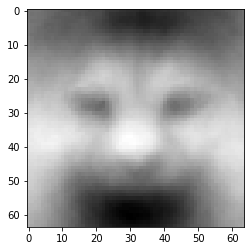

In [93]:
show_image(out,5)

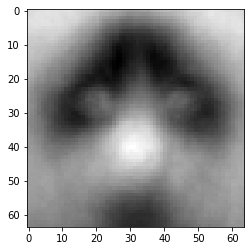

In [94]:
show_image(out,6)

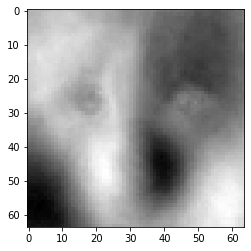

In [95]:
show_image(out,7)

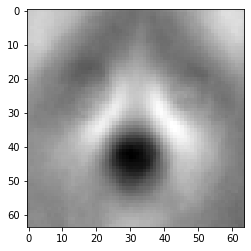

In [96]:
show_image(out,8)

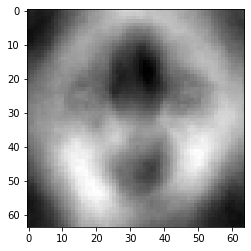

In [97]:
show_image(out,9)

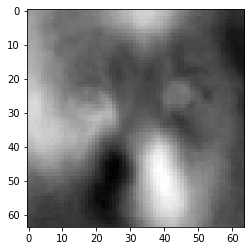

In [98]:
show_image(out,10)

In [122]:
k = 10
yguess_test4 = pca_regression(Xtrain,ytrain,Xtest, k)
yguess_train4 = pca_regression(Xtrain,ytrain,Xtrain, k)
per_test4 = calculate_accuracy(ytest, yguess_test4)
per_train4 = calculate_accuracy(ytrain, yguess_train4)
print(per_test4)
print(per_train4)

85.75
85.3125


In [123]:
k = 20
yguess_test5 = pca_regression(Xtrain,ytrain,Xtest, k)
yguess_train5 = pca_regression(Xtrain,ytrain,Xtrain, k)
per_test5 = calculate_accuracy(ytest, yguess_test5)
per_train5 = calculate_accuracy(ytrain, yguess_train5)
print(per_test5)
print(per_train5)

87.75
88.0


In [124]:
k = 50
yguess_test6 = pca_regression(Xtrain,ytrain,Xtest, k)
yguess_train6 = pca_regression(Xtrain,ytrain,Xtrain, k)
per_test6 = calculate_accuracy(ytest, yguess_test6)
per_train6 = calculate_accuracy(ytrain, yguess_train6)
print(per_test6)
print(per_train6)

91.75
92.375


In [125]:
k = 100
yguess_test7 = pca_regression(Xtrain,ytrain,Xtest, k)
yguess_train7 = pca_regression(Xtrain,ytrain,Xtrain, k)
per_test7 = calculate_accuracy(ytest, yguess_test7)
per_train7 = calculate_accuracy(ytrain, yguess_train7)
print(per_test7)
print(per_train7)

92.5
94.3125
